In [5]:
%matplotlib widget
import os
import numpy as np
import matplotlib.pyplot as plt
import importlib
from matplotlib import cycler
import torch
from torch import nn

try:
    importlib.reload(dd)
except NameError:
    import disjoint_domain as dd

try:
    importlib.reload(ddnet)
except NameError:
    import ddnet
    
try:
    importlib.reload(util)
except NameError:
    import util


simple_net_params = {
    'n_domains': 3, 'use_ctx_repr': False, 'use_ctx': False,
    'attrs_per_context': 200, 'hidden_units': 48, 'ctx_per_domain': 1,
    'fix_biases': True, 'fixed_bias': 0
}

simple_train_params = {
    'reports_per_test': np.inf, 'holdout_testing': 'domain',
    'test_thresh': 0.85, 'num_epochs': 6000, 'lr': 0.03
}

In [4]:
path_orig = ddnet.train_n_nets(n=10, run_type='final_runs/sigmoid_2hl_2domain_1ctx',
                               net_params=simple_net_params, train_params=simple_train_params)[0]

path_linear = ddnet.train_n_nets(n=100, run_type='final_runs/linear_2hl_2domain_1ctx',
                                 train_params={**simple_train_params, 'lr': 0.005},
                                 net_params={**simple_net_params, 'act_fn': nn.Identity(),
                                             'loss_fn': nn.MSELoss})[0]

path_no_cd_loss = ddnet.train_n_nets(n=100, run_type='final_runs/no_crossdomain_loss_sigmoid',
                                     net_params={**simple_net_params, 'include_cross_domain_loss': False},
                                     train_params=simple_train_params)[0]

In [6]:
# Also train each network type on ring-ring
tree_cluster_info = '4-2-2'
ring_cluster_info = {'clusters': '8', 'intragroup_dists': [12], 'rotating_overlap': 18}
ring_net_params = {**simple_net_params, 'cluster_info': ring_cluster_info}

path_ring_sigmoid = ddnet.train_n_nets(n=10, run_type='final_runs/ring_sigmoid_2hl_2domain_1ctx',
                                       net_params=ring_net_params, train_params=simple_train_params)[0]

path_ring_linear = ddnet.train_n_nets(n=100, run_type='final_runs/ring_linear_2hl_2domain_1ctx',
                                      train_params={**simple_train_params, 'lr': 0.005},
                                      net_params={**ring_net_params, 'act_fn': nn.Identity(),
                                                  'loss_fn': nn.MSELoss})[0]

path_ring_no_cd_loss = ddnet.train_n_nets(n=100, run_type='final_runs/ring_no_crossdomain_loss_sigmoid',
                                          net_params={**ring_net_params, 'include_cross_domain_loss': False},
                                          train_params=simple_train_params)[0]

Training Iteration 1
---------------------
Using CUDA
Holding out domain C
Epoch    0: loss = 138.717, weighted acc = 0.000, epochs for new domain  = 2308
Epoch   50: loss =  34.800, weighted acc = 0.283
Epoch  100: loss =  34.064, weighted acc = 0.283
Epoch  150: loss =  33.923, weighted acc = 0.283
Epoch  200: loss =  33.760, weighted acc = 0.283
Epoch  250: loss =  33.624, weighted acc = 0.283
Epoch  300: loss =  33.595, weighted acc = 0.283
Epoch  350: loss =  33.544, weighted acc = 0.283
Epoch  400: loss =  33.514, weighted acc = 0.283
Epoch  450: loss =  33.490, weighted acc = 0.283
Epoch  500: loss =  33.470, weighted acc = 0.283
Epoch  550: loss =  33.452, weighted acc = 0.283
Epoch  600: loss =  33.440, weighted acc = 0.283
Epoch  650: loss =  33.426, weighted acc = 0.283
Epoch  700: loss =  33.418, weighted acc = 0.283
Epoch  750: loss =  33.408, weighted acc = 0.283
Epoch  800: loss =  33.400, weighted acc = 0.283
Epoch  850: loss =  33.394, weighted acc = 0.283
Epoch  900: 

KeyboardInterrupt: 

In [ ]:
# Reload runs and do domain holdout testing, every 200 epochs up to 6000 epochs.

def make_different_last_domain_restorer(last_domain_cluster_info):
    def restore_nets_with_different_last_domain(res_path, epochs):
        def replace_last_domain(single_net_restorer):
            net, train_params = next(single_net_restorer)
            y = net.y
            net.last_domain_cluster_info = last_domain_cluster_info
            new_y = net.gen_training_tensors()[2]
            x_per_domain = y.shape[0] // net.n_domains
            y[-x_per_domain:] = new_y[-x_per_domain:]
            net.y = y
            yield net, train_params
            
            for net, train_params in single_net_restorer:
                net.y = y
                yield net, train_params
            return
            
        return (replace_last_domain(single_net_restorer)
                for single_net_restorer in ddnet.restore_each_net_over_epochs(res_path, epochs))

    return restore_nets_with_different_last_domain

test_paths_tree = [path_orig, path_no_cd_loss]
test_paths_ring = [path_ring_sigmoid, path_ring_no_cd_loss]
epochs = np.arange(0, 6001, 200)

for res_path in test_paths_tree:
    path_base = os.path.splitext(res_path)[0]
    ddnet.restore_and_holdout_test(res_path, epochs, path_base + 'domainho_ring.npz',
                                   make_different_last_domain_restorer(ring_cluster_info))
    ddnet.restore_and_holdout_test(res_path, epochs, path_base + 'domainho_tree.npz')
    
for res_path in test_paths_ring:
    path_base = os.path.splitext(res_path)[0]
    ddnet.restore_and_holdout_test(res_path, epochs, path_base + 'domainho_ring.npz')
    ddnet.restore_and_holdout_test(res_path, epochs, path_base + 'domainho_tree.npz',
                                   make_different_last_domain_restorer(tree_cluster_info))

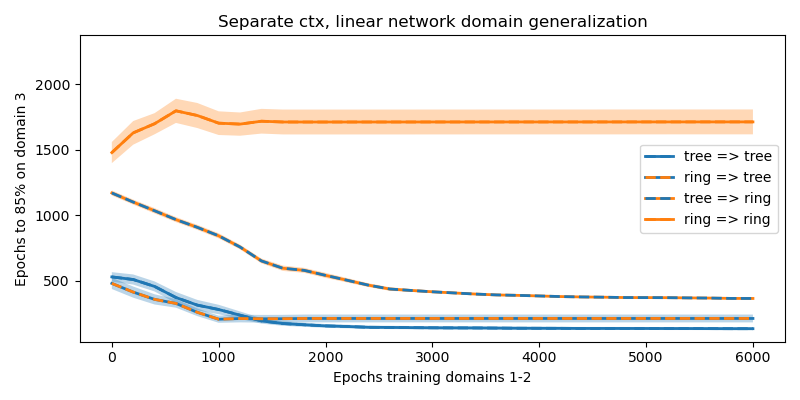

In [25]:
# Plot domain holdout results

domain_holdout_paths = {
    'Separate ctx, linear': {
        'tree => tree': 'data/final_runs/linear_2hl_2domain_1ctx_dd_res_2022-01-20_16-14-32domainho_tree.npz',
        'ring => tree': 'data/final_runs/ring_linear_2hl_2domain_1ctx_dd_res_2022-01-20_17-08-52domainho_tree.npz',
        'tree => ring': 'data/final_runs/linear_2hl_2domain_1ctx_dd_res_2022-01-20_16-14-32domainho_ring.npz',
        'ring => ring': 'data/final_runs/ring_linear_2hl_2domain_1ctx_dd_res_2022-01-20_17-08-52domainho_ring.npz',
    },
    'Separate ctx,': {
        'tree => tree': 'data/final_runs/sigmoid_2hl_2domain_1ctx_dd_res_2022-01-18_18-29-57domainho_tree.npz',
        'ring => tree': 'data/final_runs/ring_sigmoid_2hl_2domain_1ctx_dd_res_2022-01-18_17-47-32domainho_tree.npz',
        'tree => ring': 'data/final_runs/sigmoid_2hl_2domain_1ctx_dd_res_2022-01-18_18-29-57domainho_ring.npz',
        'ring => ring': 'data/final_runs/ring_sigmoid_2hl_2domain_1ctx_dd_res_2022-01-18_17-47-32domainho_ring.npz',
    },
    'Separate ctx, no cross-domain loss': {
        'tree => tree': 'data/final_runs/no_crossdomain_loss_sigmoid_dd_res_2022-01-18_18-47-03domainho_tree.npz',
        'ring => tree': 'data/final_runs/ring_no_crossdomain_loss_sigmoid_dd_res_2022-01-18_18-14-20domainho_tree.npz',
        'tree => ring': 'data/final_runs/no_crossdomain_loss_sigmoid_dd_res_2022-01-18_18-47-03domainho_ring.npz',
        'ring => ring': 'data/final_runs/ring_no_crossdomain_loss_sigmoid_dd_res_2022-01-18_18-14-20domainho_ring.npz',
    }
}

# Set color/line style cycle to highlight runs expected to have lower ETG
line_cycle = cycler(linestyle=['-', '--']) * 4  # first held-out, then trained-on
colors = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'][:2])
color_inds = np.array([(ho, train) for ho in range(2) for train in range(2)]).ravel()
color_cycle = cycler(color=colors[color_inds])
prop_cycle = line_cycle + color_cycle

n_types = len(domain_holdout_paths)
fig, axs = util.auto_subplots(n_types, 1, ax_dims=(8, 4), prop_cycle=prop_cycle)

for (label, paths), ax in zip(domain_holdout_paths.items(), axs.ravel()):
    h_lines = [[], []]  # first held-out, then trained-on
    ax.set_title(f'{label} network domain generalization')
    for path in paths.values():
        with np.load(path) as dho_file:
            mean_etg, ci_etg = util.get_mean_and_ci(dho_file['etg'])
            etg_epochs = dho_file['test_epochs']

        for line_list in h_lines:
            line_list.append(ax.plot(etg_epochs, mean_etg, lw=2)[0])
        ax.fill_between(etg_epochs, *ci_etg, alpha=0.3) # use "trained-on" color
        ax.fill_between([], []) # just advance patch cycle
    
    ax.legend(list(zip(*h_lines)), paths.keys())
    ax.set_xlabel('Epochs training domains 1-2')
    ax.set_ylabel(f'Epochs to {simple_train_params["test_thresh"] * 100:g}% ' +
                  'on domain 3')
    
    curr_ylims = ax.get_ylim()
    ax.set_ylim((curr_ylims[0], curr_ylims[1] * 1.2))

fig.tight_layout()
plt.show()

util.print_svg(fig, 'figures/dd_domain_holdout.svg')

In [52]:
# Try shared contexts, with 2 contexts, corresponding to ring and tree structures (without permuting items)
# where last (3rd) domain either has ring and tree in the same order (corresponding to the same context units) or reversed.

tree_cluster_info = '4-2-2'
ring_cluster_info = {'clusters': '8', 'intragroup_dists': [12], 'rotating_overlap': 18}

net_params = {
    'n_domains': 3, 'use_ctx_repr': False, 'use_ctx': True, 'share_ctx': True,
    'attrs_per_context': 100, 'hidden_units': 48, 'ctx_per_domain': 2,
    'fix_biases': True, 'fixed_bias': 0, 'cluster_info': [tree_cluster_info, ring_cluster_info]
}

train_params = {
    'reports_per_test': 4, 'holdout_testing': 'domain',
    'test_thresh': 0.85, 'num_epochs': 6000, 'lr': 0.01
}

ddnet.train_n_nets(n=100, run_type='final_runs/2ctx_shared_treering_same',
                   net_params=net_params, train_params=train_params)

ddnet.train_n_nets(n=100, run_type='final_runs/2ctx_shared_treering_diff',
                   net_params={**net_params, 'last_domain_cluster_info': [ring_cluster_info, tree_cluster_info]},
                               train_params=train_params)

# also share output attributes within each domain, to be more like the family tree network
net_params_sharedoutputs = {**net_params, 'attrs_per_context': 200, 'share_attr_units_in_domain': True,
                            'repeat_attrs_over_domains': True}

ddnet.train_n_nets(n=100, run_type='final_runs/2ctx_shared_sharedoutput_treering_same',
                   net_params=net_params_sharedoutputs, train_params=train_params)

ddnet.train_n_nets(n=100, run_type='final_runs/2ctx_shared_sharedoutput_treering_diff',
                   net_params={**net_params_sharedoutputs, 'last_domain_cluster_info': [ring_cluster_info, tree_cluster_info]},
                               train_params=train_params)

Training Iteration 1
---------------------
Using CUDA
Holding out domain C
Epoch    0: loss = 416.261, weighted acc = 0.000, epochs for new domain  = 1861
Epoch   50: loss =  71.765, weighted acc = 0.405
Epoch  100: loss =  71.032, weighted acc = 0.402
Epoch  150: loss =  71.043, weighted acc = 0.390
Epoch  200: loss =  70.953, weighted acc = 0.385, epochs for new domain  = 1716
Epoch  250: loss =  70.832, weighted acc = 0.385
Epoch  300: loss =  70.801, weighted acc = 0.387
Epoch  350: loss =  70.310, weighted acc = 0.386
Epoch  400: loss =  68.832, weighted acc = 0.392, epochs for new domain  = 1358
Epoch  450: loss =  63.743, weighted acc = 0.435
Epoch  500: loss =  60.184, weighted acc = 0.435
Epoch  550: loss =  58.195, weighted acc = 0.434
Epoch  600: loss =  57.914, weighted acc = 0.438, epochs for new domain  = 1519
Epoch  650: loss =  58.099, weighted acc = 0.434
Epoch  700: loss =  56.648, weighted acc = 0.434
Epoch  750: loss =  55.038, weighted acc = 0.436
Epoch  800: loss 

('data/final_runs/2ctx_shared_sharedoutput_treering_diff_dd_res_2022-01-28_03-58-51.npz',
 DisjointDomainNet(
   (criterion): BCELoss()
   (item_to_rep): Linear(in_features=24, out_features=16, bias=False)
   (ctx_to_rep): Identity()
   (rep_to_hidden): Linear(in_features=18, out_features=48, bias=False)
   (hidden_to_attr): Linear(in_features=48, out_features=600, bias=False)
 ))